# Logistic Regression Classifier
In this exercise, we'll experiment with a decision tree classifier.  We'll explore the concept of over-fitting and how to prevent it.
See [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

## Acknowledgements
Much of this work draws on material originally presented by Joe Findlay to the Fort Collins Data Science Meetup in June 2018.  See https://github.com/findaz/FoCoAstronomy. Also the feature set used in the modeling came from Coursera [Data Driven Astronomy](https://www.coursera.org/learn/data-driven-astronomy/home/welcome)

## Citation

[Scikit-learn: Machine Learning in Python](http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html)


In [1]:
import numpy as np
import pandas as pd

In [2]:
# Set up matplotlib and use a nicer set of plot parameters

import matplotlib.pyplot as plt

%matplotlib inline


For this exercises, we'll classify galactic objects based on their spectral characteristics.  We'll use data obtained from the [Sloan Digital Sky Survey](https://www.sdss.org/surveys/). The data has previously been downloaded into a `csv` file for convenience. Here's the Python code that produced the data set we'll be working with:

```python
from astroquery.sdss import SDSS

# query quasars and galaxies
NOBJECTS = 40000
query_text = ('\n'.join(
    ("SELECT TOP %i" % NOBJECTS,
    "   p.objid, s.class as objtype, p.u, p.g, p.r, p.i, p.z, s.z as redshift, s.zerr as redshift_err",
    "FROM PhotoObj AS p",
    "   JOIN SpecObj AS s ON s.bestobjid = p.objid",
    "WHERE ",
    "   p.u BETWEEN 0 AND 19.6",
    "   AND p.g BETWEEN 0 AND 20" ,
    "   AND (s.class = 'GALAXY' OR s.class = 'QSO' or s.class = 'STAR')")))
    
res = SDSS.query_sql(query_text)

df = res.to_pandas()

```
The resulting data frame, `df` was written to a `.csv` file called `star_data.csv` in the `data` folder of the current repo.

## Load the Data

In [3]:
path = 'data/star_data.csv'

In [4]:
stars = pd.read_csv(path)

In [5]:
stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 9 columns):
objid           40000 non-null int64
objtype         40000 non-null object
u               40000 non-null float64
g               40000 non-null float64
r               40000 non-null float64
i               40000 non-null float64
z               40000 non-null float64
redshift        40000 non-null float64
redshift_err    40000 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 2.7+ MB


In [6]:
stars.head()

,objid,objtype,u,g,r,i,z,redshift,redshift_err
0,1237646794381525062,STAR,17.71780,16.05344,15.16819,14.89321,14.61744,0.000034,0.000009
1,1237646794381525090,STAR,17.97407,16.40579,15.61678,15.31425,15.04014,0.000086,0.000011
2,1237646794381525242,STAR,18.27456,16.51688,15.63467,15.31055,15.00995,-0.000019,0.000009
3,1237646794381525254,STAR,18.88846,17.16243,16.63293,16.46195,16.21572,0.000143,0.000010
4,1237646794381525280,STAR,18.29142,16.58741,15.70286,15.37309,15.07583,-0.000040,0.000009


## Exploratory Data Analysis

We're going to build a classifier which predicts an object's `objtype` based on it's spectral characteristics `u`, `g`, `r`, `i` and `z`. What is the set of object types and how prevelant is each in the data set? Use something like:
```python
stars.groupby('objtype').count().objid
```
to find out.

In [7]:
stars.groupby('objtype').count().objid

objtype
GALAXY    18987
QSO        3766
STAR      17247
Name: objid, dtype: int64

To see it visually, try this:
```python
stars.groupby('objtype').count()['objid'].plot.bar()
```

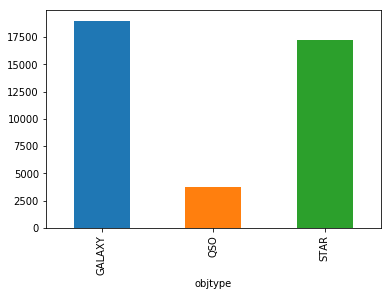

In [8]:
stars.groupby('objtype').count()['objid'].plot.bar()

In [9]:
types = ['STAR', 'QSO', 'GALAXY']
colors = ['red', 'green', 'blue']

Let's see how the object types map out relative to the spectral measurements.
Try this:
```
fig, ax = plt.subplots(ncols=3, figsize=(12,4), sharey=True, sharex=True)
for t,c,a in zip(types, colors,ax):
    df = stars.query('objtype == @t')
    a.scatter(df.u, df.g, color=c, label=t)
    a.legend()
plt.tight_layout()
```
and repeat for the  `(r,i)` and `(i,z)` spectral pairs.

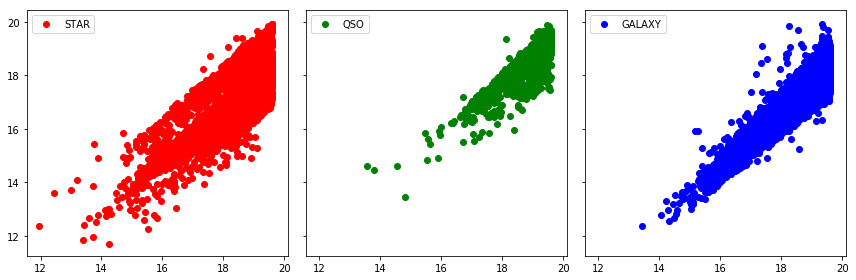

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4), sharey=True, sharex=True)
for t,c,a in zip(types, colors,ax):
    df = stars.query('objtype == @t')
    a.scatter(df.u, df.g, color=c, label=t)
    a.legend()
plt.tight_layout()

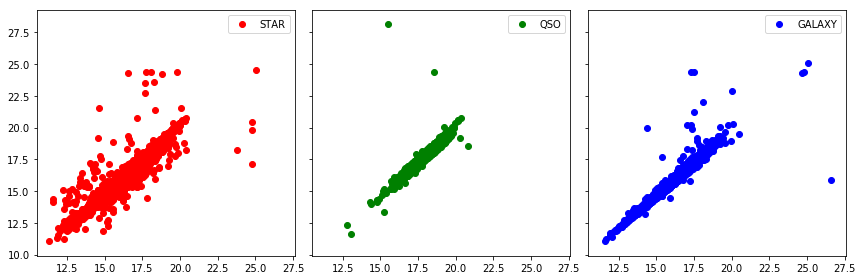

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4), sharey=True, sharex=True)
for t,c,a in zip(types, colors,ax):
    df = stars.query('objtype == @t')
    a.scatter(df.r, df.i, color=c, label=t)
    a.legend()
plt.tight_layout()

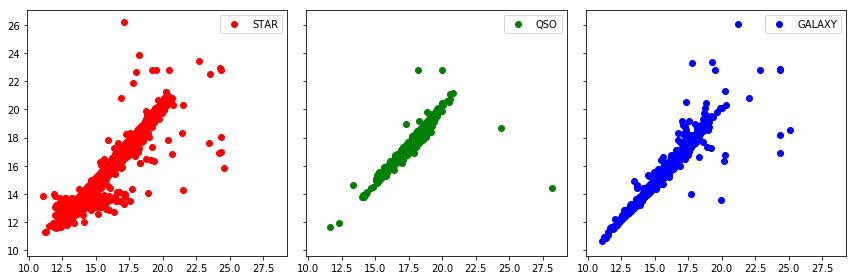

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(12,4), sharey=True, sharex=True)
for t,c,a in zip(types, colors,ax):
    df = stars.query('objtype == @t')
    a.scatter(df.i, df.z, color=c, label=t)
    a.legend()
plt.tight_layout()

## Data Wrangling

In [13]:
# some needed libraries
from sklearn.model_selection import train_test_split # to partition the dataset into training and test
from sklearn.metrics import accuracy_score, confusion_matrix # for model evaluation
from sklearn.tree import DecisionTreeClassifier # classifier model to test

The Coursera course cited above uses the __difference__ in adjacent spectral intensities as the features in its classification model.  Here we'll construct 4 features:
1. U minus G
1. G minus R
1. R minus I
1. I minus Z

In [14]:
# function to create features from input data set
# returns (n,4) feature matrix and (n,) label vector
def get_features_labels(df):
    features = np.zeros((len(df), 4))
    features[:,0] = df.u-df.g
    features[:,1] = df.g-df.r
    features[:,2] = df.r-df.i
    features[:,3] = df.i-df.z
    labels = df.objtype
    return features, labels

In [15]:
#get list of all possible labels (need this later)
labs = stars.objtype.unique().tolist()

Use the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function in [sklearn.model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) to create an 80%/20% training and test split of the `stars` data frame.

In [16]:
# partition data into training and test, 20% test
trainingSet, testSet = train_test_split(stars, test_size=0.2)

We further want to partition the training set into a developement and validation set so that we can do model development and hyper-parameter selection without touching the test data

In [17]:
# further split training set into devel and validation, 20% validation
devSet, valSet = train_test_split(trainingSet, test_size = 0.2)

Now, get the features and labels from  each of the data sets: `dev`, `val` and `test`. 

In [18]:
#get the features and labels for each of the sets
x_dev,  y_dev  = get_features_labels(devSet)
x_val,  y_val  = get_features_labels(valSet)
x_test, y_test = get_features_labels(testSet)

## Decision Tree Classifier
To use this technique, create a `DecisionTreeClassifier` object, as in:
```python
dtc = DecisionTreeClassifier()
```
then fit the model using the development set as argument to object's `.fit` method:
```python
dtc.fit(x_dev, y_dev)
```

In [19]:
dtc = DecisionTreeClassifier()
dtc.fit(x_dev, y_dev)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Compute accuracy for both the developement and the validation test sets. The decision tree object's `predict` method will make predictions given a input feature matrix; `sklean.metric.accuracy_score` will compute accuracy from the true labels compared to the predicted labels, as in:
```python
# calculate prediction accuracy on the dev set
pred_dev = dtc.predict(x_dev)
acc_dev = accuracy_score(y_dev, pred_dev)
```
In the cell below, compute the accuracy on the training dataset and the validation dataset.

In [20]:
# calculate prediction accuracy on the dev set
pred_dev = dtc.predict(x_dev)
acc_dev = accuracy_score(y_dev, pred_dev)

#calculate prediction accuracy on the validation set
pred_val = dtc.predict(x_val)
acc_val = accuracy_score(y_val, pred_val)

print('Training Set Accuracy: ', acc_dev)
print('Validation Set Accuracy: ', acc_val)

Training Set Accuracy:  1.0
Validation Set Accuracy:  0.94546875


`sklearn.metrics.confustion_matrix` will show counts of the actual labels versus the predicted labels for each of the labels in the data sets.  It takes two arguments, the first is the vector of true labels, the second is the vector of predicted labels.  Call it as follows:
```python
cm = pd.DataFrame(confusion_matrix(y_val, pred_val, labels=labs),
                        index=labs, columns=labs)
```
Wrapping the function in a data frame as above puts the class labels on the result, making it easier to interpret.

In [21]:
cm = pd.DataFrame(confusion_matrix(y_val, pred_val, labels=labs),
                        index=labs, columns=labs)

# display it
cm

,STAR,GALAXY,QSO
STAR,2618,106,23
GALAXY,113,2860,37
QSO,24,46,573


## Exploring Overfitting
Decision Trees are notorious for overfitting. Left to its own devices, a decision tree estimation algorithm will build as complex a decision tree as it needs in order to fit all of the data.  Doing so makes it prone to prediction errors when the model encounters data that it hasn't seen before.

In this section, we'll explore how the prediction accuracy on the development and validation data sets varies as a function of tree depth.  To do this, we need a function that will compute development and validation accuracy for a tree of a given depth.  The function should look something like the following:
```python
def dev_val_acc(x_dev, y_dev, x_val, y_val, max_depth):
    """
    computes development and validation set accuracy for a decision tree of a specified maximum depth
    """
    #create and fit the tree on the dev set
    dtc = DecisionTreeClassifier(max_depth=max_depth)
    dtc.fit(x_dev, y_dev)
    
    #compute dev set accuracy
    pred_dev = dtc.predict(x_dev)
    acc_dev = accuracy_score(pred_dev, y_dev)
    
    #compute validation set accuracy
    pred_val = dtc.predict(x_val)
    acc_val = accuracy_score(pred_val, y_val)
    
    #return the results
    return (max_depth, acc_dev, acc_val)
```

In [22]:
#Your code here
def dev_val_acc(x_dev, y_dev, x_val, y_val, max_depth):
    """
    computes development and validation set accuracy for a decision tree of a specified maximum depth
    """
    #create and fit the tree on the dev set
    dtc = DecisionTreeClassifier(max_depth=max_depth)
    dtc.fit(x_dev, y_dev)
    
    #compute dev set accuracy
    pred_dev = dtc.predict(x_dev)
    acc_dev = accuracy_score(pred_dev, y_dev)
    
    #compute validation set accuracy
    pred_val = dtc.predict(x_val)
    acc_val = accuracy_score(pred_val, y_val)
    
    #return the results
    return (max_depth, acc_dev, acc_val)

In [23]:
# test out on a tree 10-deep
dev_val_acc(x_dev, y_dev, x_val, y_val, 10)

(10, 0.97609374999999998, 0.95625000000000004)

Run the routine above on tree depths ranging from 1 to 30.  Store the result in a data frame for easy plotting later.  The code to do so should look someting like:
```python
model_score = pd.DataFrame([dev_val_acc(x_dev, y_dev, x_val, y_val,i) for i in range(1,30)],
                          columns=['TreeDepth','DevAcc','ValAcc'])
```

In [24]:
model_score = pd.DataFrame([dev_val_acc(x_dev, y_dev, x_val, y_val,i) for i in range(1,30)],
                          columns=['TreeDepth','DevAcc','ValAcc'])

In [25]:
model_score.head()

,TreeDepth,DevAcc,ValAcc
0,1,0.802031,0.793438
1,2,0.863867,0.865000
2,3,0.898906,0.898438
3,4,0.908867,0.908281
4,5,0.943359,0.938594


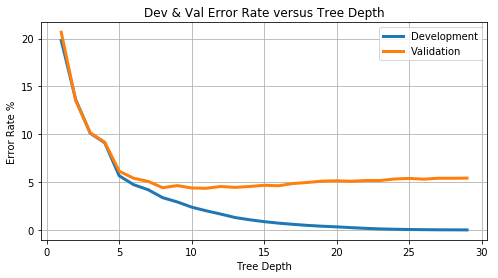

In [26]:
fig = plt.figure(figsize=(8,4))


ax1 = plt.subplot()

ax1.set_title('Dev & Val Error Rate versus Tree Depth')

ax1.plot(model_score.TreeDepth, 100.0*(1.0-model_score.DevAcc), linewidth=3, label = 'Development')
ax1.plot(model_score.TreeDepth, 100.0*(1.0-model_score.ValAcc), linewidth=3, label = 'Validation')
ax1.set_ylabel('Error Rate %')
ax1.set_xlabel('Tree Depth')
ax1.grid()

ax1.legend()

The figure above is a classic illustration of over fitting.  In the figure, the error rate decreases continuously until it reaches zero, where as the error rate on the validation set drops for a bit, but then begins to increase as the model gets more complex (the decision tree gets deeper).

The model with the least __validation__ error is the model we want to go with. Here we determine at what tree depth the least validation error occurs.

In [27]:
#index in the data frame of the highest validation set accuracy:
model_score.ValAcc.values.argmax()

10

In [28]:
# tree depth of the highest validation set accuracy:
max_depth = model_score.TreeDepth[ model_score.ValAcc.values.argmax() ]
print('Tree depth of Highest Validation Set Accuracy: %d' % max_depth)

Tree depth of Highest Validation Set Accuracy: 11


## Test Set Accuracy
Now we know the value of the max_depth hyperparameter for our model, let's see how accurate we are on the test data set: data which we haven't encountered until now.

First, reestimate the model on the combined development and validation data sets. To do so, stack them on top of each other, for both the feature matrix and the label vector. `np.vstack` is the tool for the job here, as in:
```python
x_train = np.vstack([x_dev, x_val])
y_train = np.vstack([y_dev.values.reshape(-1,1), y_val.values.reshape(-1,1)])
```
The reshaping of the y values is necessary because the `get_features_label` function above returns the y labels as a `Pandas.Series` as opposed to an `ndarray`.

In [29]:
# estimate the model on the combined dev and val sets
x_train = np.vstack([x_dev, x_val])
y_train = np.vstack([y_dev.values.reshape(-1,1), y_val.values.reshape(-1,1)])

Now create and fit the model on the combined data set and use the max_depth parameter, as in:
```python
dtc_md = DecisionTreeClassifier(max_depth=max_depth)
dtc_md.fit(x_train, y_train)
```

In [30]:
dtc_md = DecisionTreeClassifier(max_depth=max_depth) #max_depth computed above
dtc_md.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Compute accuracy for both the developement and the test sets. The decision tree object's `predict` method will make predictions given a input feature matrix; `sklean.metric.accuracy_score` will compute accuracy from the true labels compared to the predicted labels, as in:
```python
# calculate prediction accuracy on the training set
pred_train_md = dtc_md.predict(x_train)
acc_train_md = accuracy_score(y_train, pred_train_md)
```
In the cell below, compute the accuracy on the training dataset and the test datasets.

In [31]:
# calculate prediction accuracy on the training set
pred_train_md = dtc_md.predict(x_train)
acc_train_md = accuracy_score(y_train, pred_train_md)

#calculate prediction accuracy on the test set
pred_test_md = dtc_md.predict(x_test)
acc_test_md = accuracy_score(y_test, pred_test_md)

print('Training Set Accuracy: ', acc_train_md)
print('Test Set Accuracy: ', acc_test_md)

Training Set Accuracy:  0.98021875
Test Set Accuracy:  0.95275


`sklearn.metrics.confustion_matrix` will show counts of the actual labels versus the predicted labels for each of the labels in the data sets.  It takes two arguments, the first is the vector of true labels, the second is the vector of predicted labels.  Call it as follows:
```python
cm_md = pd.DataFrame(confusion_matrix(y_test, pred_test_md, labels=labs),
                        index=labs, columns=labs)
```
Wrapping the function in a data frame as above puts the class labels on the result, making it easier to interpret.

In [32]:
cm_md = pd.DataFrame(confusion_matrix(y_test, pred_test_md, labels=labs),
                        index=labs, columns=labs)

# display it
cm_md

,STAR,GALAXY,QSO
STAR,3323,99,19
GALAXY,148,3633,32
QSO,24,56,666


## Model Comparison
Let's compare how the unconstrained (overfitting) model and the constrained (max_depth) model perform on the test data set.

In [33]:
#compute the accuracy on the test set of the unconstrained model
pred_test = dtc.predict(x_test)
acc_test = accuracy_score(y_test, pred_test)

In [34]:
#make a data frame for tabluar comparison of results
mod_res=pd.DataFrame([[acc_dev, acc_test], [acc_train_md, acc_test_md]],
                    columns=['Development','Test'],
                    index=['Unconstrained','MaxDepth='+str(max_depth)])

In [35]:
mod_res

,Development,Test
Unconstrained,1.000000,0.941625
MaxDepth=11,0.980219,0.952750


Text(0.5,0,'Model Type')

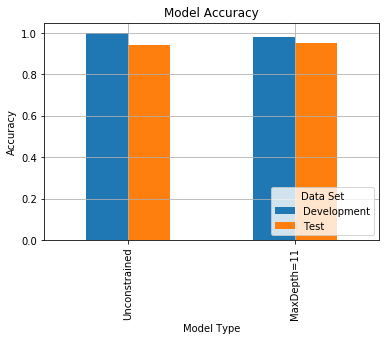

In [36]:
# show graphically
ax=mod_res.plot.bar(title='Model Accuracy')
ax.legend(loc='lower right', title='Data Set')
ax.set_ylabel('Accuracy')
ax.grid()
ax.set_xlabel('Model Type')

## Conclusion
Over-fitting leads to overstating the accuracy of the classifier.  Constraining the model to counteract the overfitting leads to a better estimate of how well the model will do when presented with data it hasn't seen before.

Hopefully you've learned how to construct a decision tree classifier, detect overfitting and correct for its ill effects.